<a href="https://colab.research.google.com/github/AdamPang4339/EvaluationOfFederatedLearning/blob/main/DATA_POISONED_VERSION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing Flower dependencies

In [ ]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 478.6/478.6 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not current

Necessary Imports

In [ ]:
from typing import List, Union, Tuple, Dict, Optional
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

from collections import OrderedDict

import flwr
from flwr.server.client_proxy import ClientProxy
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context, EvaluateRes, FitRes, Scalar
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import NaturalIdPartitioner

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(f"Training on {DEVICE}")
disable_progress_bar()

Training on cpu


Loading FEMNIST dataset and split up into train, test, and validation sets. Working with 10 clients for our FL model.

In [ ]:
NUM_CLIENTS = 10
BATCH_SIZE = 64

def load_datasets(partition_id: int):
  '''
  Function loads different parts of the FEMNIST dataset depending on the partition
  ID specified as a parameter. We have 10 clients in our simulation, so we will be using
  10 partition IDs.
  '''
  # Split FEMNIST dataset into 10 partitions
  fds = FederatedDataset(
      dataset="flwrlabs/femnist",
      partitioners={"train": NUM_CLIENTS}
  )
  partition = fds.load_partition(partition_id)

  # Divide data in each partition: 80% train, 20% test
  # Note: We use a set seed to make sure the results are reproducible
  partition_train_test = partition.train_test_split(test_size=0.2, seed=21)

  # Normalize and convert images to PyTorch tensors for more stable training
  pytorch_transforms = transforms.Compose(
      [transforms.ToTensor(), transforms.Normalize((0.5), (0.5))]
  )

  def apply_transforms(batch):
    '''
    Applies transformations of pytorch_transforms on every image in place
    '''
    batch["image"] = [pytorch_transforms(img) for img in batch["image"]]

    if (partition_id == 0):
      for i in range(len(batch["character"]) // 2):
        batch["character"][i] = (batch["character"][i] + 1) % 62

    return batch

  # Create train/val for each partition and wrap it into DataLoader
  partition_train_test = partition_train_test.with_transform(apply_transforms)
  trainloader = DataLoader(
      partition_train_test["train"], batch_size=BATCH_SIZE, shuffle=True
  )

  # Generate DataLoaders for the validation and test data batches
  # Generate testset as the whole dataset
  valloader = DataLoader(partition_train_test["test"], batch_size=BATCH_SIZE)
  testset = fds.load_split("train").with_transform(apply_transforms)
  testloader = DataLoader(testset, batch_size=BATCH_SIZE)

  return trainloader, valloader, testloader

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Testing the data load process

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


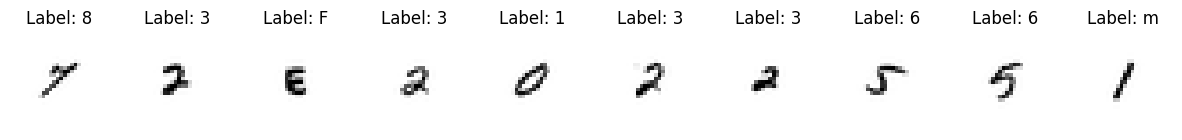

In [ ]:
# Testing with partition id 0
trainloader, _, _ = load_datasets(partition_id=0)
num_images = 10

# Get a batch of images
batch = next(iter(trainloader))
images, labels = batch["image"], batch["character"]

# Create a grid of subplots
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i in range(num_images):
    # Get image and label
    img = images[i].numpy()  # Convert to numpy array
    label = trainloader.dataset.features["character"].int2str([labels[i]])[0]        # Labels have been converted to their characters

    # Rescale image back to [0, 1]
    img = (img * 0.5) + 0.5  # Unnormalize the image (if using mean=0.5, std=0.5)

    # Display image
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].set_title(f"Label: {label}")  # Display label
    axes[i].axis('off')  # Hide axes

plt.show()

# Initial Global Model CNN

Model architecture CNN template from https://github.com/TalwalkarLab/leaf/blob/master/models/femnist/cnn.py

In [ ]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 62)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Training and testing functions for CNN model

In [ ]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["image"].to(DEVICE), batch["character"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["image"].to(DEVICE), batch["character"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

Train model and gather metrics

In [ ]:
trainloader, valloader, testloader = load_datasets(partition_id=0)
net = Net().to(DEVICE)

for epoch in range(5):
  train(net, trainloader, 5)
  loss, accuracy = test(net, valloader)
  print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch 1: validation loss 0.02165199771759537, accuracy 0.40365958491956283
Epoch 2: validation loss 0.020183425050365623, accuracy 0.40611568218101435
Epoch 3: validation loss 0.019586019099937176, accuracy 0.4126857423553973
Epoch 4: validation loss 0.0194268944653454, accuracy 0.410720864546236
Epoch 5: validation loss 0.01920128367492641, accuracy 0.4106594621146997
Final test set performance:
	loss 0.018840919514337716
	accuracy 0.41995045911894846


# Federated Learning Model

Create a class for writing our metrics into a csv

In [ ]:
# MetricsWriter class in charge of writing all metrics results to a CSV file
class MetricsWriter:
  def __init__(self, filename: str):
    self.filename = filename
    self.file_path = os.path.join('/content', self.filename)
    if not os.path.exists(self.file_path):
      self.metrics = pd.DataFrame(columns=["client_id", "loss", "accuracy"])
    else:
      self.metrics = pd.read_csv(self.file_path)

  def write_per_client(self, client_id: int, loss: float, accuracy: float):
    new_row = pd.DataFrame({"client_id": client_id, "loss": loss, "accuracy": accuracy}, index=[0])
    self.metrics = pd.concat([self.metrics, new_row], ignore_index=True)
    self.metrics.to_csv(self.filename, index=False)

  def write_aggregated(self, round: int, loss: float, accuracy: float):
    new_row = pd.DataFrame({"round": round, "agg_loss": loss, "agg_accuracy": accuracy}, index=[0])
    self.metrics = pd.concat([self.metrics, new_row], ignore_index=True)
    self.metrics.to_csv(self.filename, index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


This defines the helper methods for upating model parameters

In [ ]:
def set_parameters(net, parameters: list[np.ndarray]):
  """ Used to update the local model with parameters received from the server """
  params_dict = zip(net.state_dict().keys(), parameters)
  state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
  net.load_state_dict(state_dict, strict=True)


def get_parameters(net) -> list[np.ndarray]:
  """ Used to get the parameters from the local model """
  return [val.cpu().numpy() for _, val in net.state_dict().items()]

This next part creates a Client Application

In [ ]:
class FlowerClient(NumPyClient):
    """ This is a class for a Federated Learning Client.

    It defines the methods that a client can use for local training
    and evaluation of the local model. Each instnace of the class represents
    a single client.
    """
    def __init__(self, net, trainloader, valloader, partition_id):
      self.net = net
      self.trainloader = trainloader
      self.valloader = valloader
      self.partition_id = partition_id

    def get_parameters(self, config):
      """ Get the parameters of the model """
      return get_parameters(self.net)

    def fit(self, parameters, config):
      """ Get parameters from server, train model, return to server.

      This method recieves the model parameters from the server and then
      trains the model on the local data. After that, the updated model
      parameters are returned to the server.
      """
      set_parameters(self.net, parameters)
      train(self.net, self.trainloader, epochs=1)
      return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
      """ Get parameters from server, evaluate model, return to server.

      This method recieves the model parameters from the server and then
      evaluates the model on the local data. After that, the evaluation
      results are returned to the server.
      """
      set_parameters(self.net, parameters)
      loss, accuracy = test(self.net, self.valloader)

      writer = MetricsWriter(filename="metrics_per_client.csv")
      writer.write_per_client(client_id=self.partition_id, loss=loss, accuracy=accuracy)

      return float(loss), len(self.valloader), {"client_id": self.partition_id, "accuracy": float(accuracy), "loss": float(loss)}

This is the function that retrieves an instance of a client. Once the client has done it's job it will be discarded to free up memory space. This is done because in our case, all the clients and the server are existing on the same machine.


The client object is an instance of ClientApp which will automatically select a client to run training and evaluation.

In [ ]:
def client_fn(context: Context) -> Client:
  """Create a Flower client representing a single organization.

  This method will return an instance of a particular client to call
  fit or evaluate. The client is then discarded after use. This frees up
  memory usage since all clients and the server are being hosted on the
  same machine.
  """

  # Load model
  net = Net().to(DEVICE)

  # Load data (CIFAR-10)
  # Note: each client gets a different trainloader/valloader, so each client
  # will train and evaluate on their own unique data partition
  # Read the node_config to fetch data partition associated to this node
  partition_id = context.node_config["partition-id"]
  trainloader, valloader, _ = load_datasets(partition_id=partition_id)

  # Create a single Flower client representing a single organization
  # FlowerClient is a subclass of NumPyClient, so we need to call .to_client()
  # to convert it to a subclass of `flwr.client.Client`
  return FlowerClient(net, trainloader, valloader, partition_id).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

Create a custom Strategy class that is a subset of FedAvg

In [ ]:
class AggregateCustomMetricStrategy(FedAvg):
    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation accuracy using weighted average."""

        if not results:
            return None, {}

        # Call aggregate_evaluate from base class (FedAvg) to aggregate loss and metrics
        aggregated_loss, aggregated_metrics = super().aggregate_evaluate(
            server_round, results, failures
        )

        # Weigh accuracy of each client by number of examples used
        accuracies = [r.metrics["accuracy"] * r.num_examples for _, r in results]
        examples = [r.num_examples for _, r in results]

        # Aggregate accuracy
        aggregated_accuracy = sum(accuracies) / sum(examples)

        # Write aggregated accuracy to our metrics CSV file
        writer = MetricsWriter(filename="metrics.csv")
        writer.write_aggregated(round=server_round, loss=aggregated_loss, accuracy=aggregated_accuracy)

        # For each of our client's results, write the client id, loss and accuracy to our metrics CSV file
        for _, r in results:
          writer.write_per_client(client_id=r.metrics["client_id"], loss=r.metrics["loss"], accuracy=r.metrics["accuracy"])


        # Return aggregated loss and metrics (i.e., aggregated accuracy)
        return aggregated_loss, {"accuracy": aggregated_accuracy}


In [ ]:
def weighted_average(metrics: list[tuple[int, Metrics]]) -> Metrics:
  # Multiply accuracy of each client by number of examples used
  accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
  examples = [num_examples for num_examples, _ in metrics]

  # Aggregate and return custom metric (weighted average)
  return {"accuracy": sum(accuracies) / sum(examples)}

This is the function that creates an instance of a server. It uses an instance of ServerConfig and the Federated Learning strategy to create a ServerAppComponents object containing all of the settings that define the behavior of the server

In [ ]:
def server_fn(context: Context) -> ServerAppComponents:
  """Construct components that set the ServerApp behaviour.

  Uses an instance of ServerConfig and the Federated Learning strategy
  to create a ServerAppComponents object containing all of the settings
  that define the behavior of the ServerApp.
  """

  # Create FedAvg strategy
  # This is the Federated Learning strategy that details the approach
  #   to the federated learning. This one uses the built-in
  #   Federated Averaging (FedAvg) with some customizations.

  #strategy = FedAvg(
      #fraction_fit=1.0,  # Sample 100% of available clients for training
      #fraction_evaluate=1.0,  # Sample 50% of available clients for evaluation
      #min_fit_clients=10,  # Never sample fewer than 10 clients for training
      #min_evaluate_clients=10,  # Never sample fewer than 5 clients for evaluation
      #min_available_clients=10,  # Wait until all 10 clients are available
      #evaluate_metrics_aggregation_fn=weighted_average, # use the weighted_average
  #)

  strategy = AggregateCustomMetricStrategy(
      fraction_fit=1.0,  # Sample 100% of available clients for training
      fraction_evaluate=1.0,  # Sample 50% of available clients for evaluation
      min_fit_clients=10,  # Never sample fewer than 10 clients for training
      min_evaluate_clients=10,  # Never sample fewer than 5 clients for evaluation
      min_available_clients=10,  # Wait until all 10 clients are available
      # evaluate_metrics_aggregation_fn=weighted_average, # use the weighted_average
  )

  # Configure the server for 5 rounds of training
  config = ServerConfig(num_rounds=5)

  return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

Specify the amount of resources each client can use

In [ ]:
# Specify the resources each of your clients need
# By default, each client will be allocated 1x CPU and 0x GPUs
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}


##### May not need this if we never plan to run on CUDA
# When running on GPU, assign an entire GPU for each client
if DEVICE.type == "cuda":
  backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}
  # Refer to our Flower framework documentation for more details about Flower simulations
  # and how to set up the `backend_config`

Run the simulation with the specified server, client app, number of nodes and backend_config

In [ ]:
NUM_CLIENTS = 10


run_simulation(
  server_app=server,
  client_app=client,
  num_supernodes=NUM_CLIENTS,
  backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=6154) 2024-10-16 22:36:01.015682: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=6154) 2024-10-16 22:36:01.072856: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=6154) 2024-10-16 22:36:01.092016: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=6154) 2024-10-16 22:36:04.263229: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning:

Visualization of Results

In [ ]:
def visualize_results(file_name):
  # Read the CSV file
  file_path = os.path.join('/content', file_name)
  data = pd.read_csv(file_path)

  # Fill in round number for
  data['round'] = data['round'].fillna(method='ffill')

  # Drop rows where 'client_id' is NaN, to avoid plotting aggregated data as individual clients
  client_data = data.dropna(subset=['client_id'])

  # Create a figure with subplots
  fig, axis = plt.subplots(2, 2, figsize=(12, 10))
  fig.suptitle('Federated Learning Metrics', fontsize=16)

  # 1. History of loss per client over rounds
  for client_id in client_data['client_id'].unique():
    client_df = client_data[client_data['client_id'] == client_id]
    axis[0, 0].plot(client_df['round'], client_df['loss'], marker='o', label=f'Client {client_id}')

  axis[0, 0].set_title('Loss per Client Over Rounds')
  axis[0, 0].set_xlabel('Rounds')
  axis[0, 0].set_ylabel('Loss')
  axis[0, 0].legend()
  axis[0, 0].grid()

  # 2. History of average loss among clients over rounds
  average_loss = data.groupby('round')['agg_loss'].mean()
  axis[0, 1].plot(average_loss.index, average_loss.values, marker='o', color='orange')
  axis[0, 1].set_title('Average Loss Among Clients Over Rounds')
  axis[0, 1].set_xlabel('Rounds')
  axis[0, 1].set_ylabel('Average Loss')
  axis[0, 1].grid()

  # 3. History of evaluation accuracy per client over rounds
  for client_id in client_data['client_id'].unique():
    client_df = client_data[client_data['client_id'] == client_id]
    axis[1, 0].plot(client_df['round'], client_df['accuracy'], marker='o', label=f'Client {client_id}')

  axis[1, 0].set_title('Evaluation Accuracy per Client Over Rounds')
  axis[1, 0].set_xlabel('Rounds')
  axis[1, 0].set_ylabel('Accuracy')
  axis[1, 0].legend()
  axis[1, 0].grid()

  # 4. History of average evaluation accuracy among clients over rounds
  average_accuracy = data.groupby('round')['agg_accuracy'].mean()
  axis[1, 1].plot(average_accuracy.index, average_accuracy.values, marker='o', color='green')
  axis[1, 1].set_title('Average Evaluation Accuracy Among Clients Over Rounds')
  axis[1, 1].set_xlabel('Rounds')
  axis[1, 1].set_ylabel('Average Accuracy')
  axis[1, 1].grid()

  # Adjust layout
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

<ipython-input-19-53df553acde2>:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['round'] = data['round'].fillna(method='ffill')


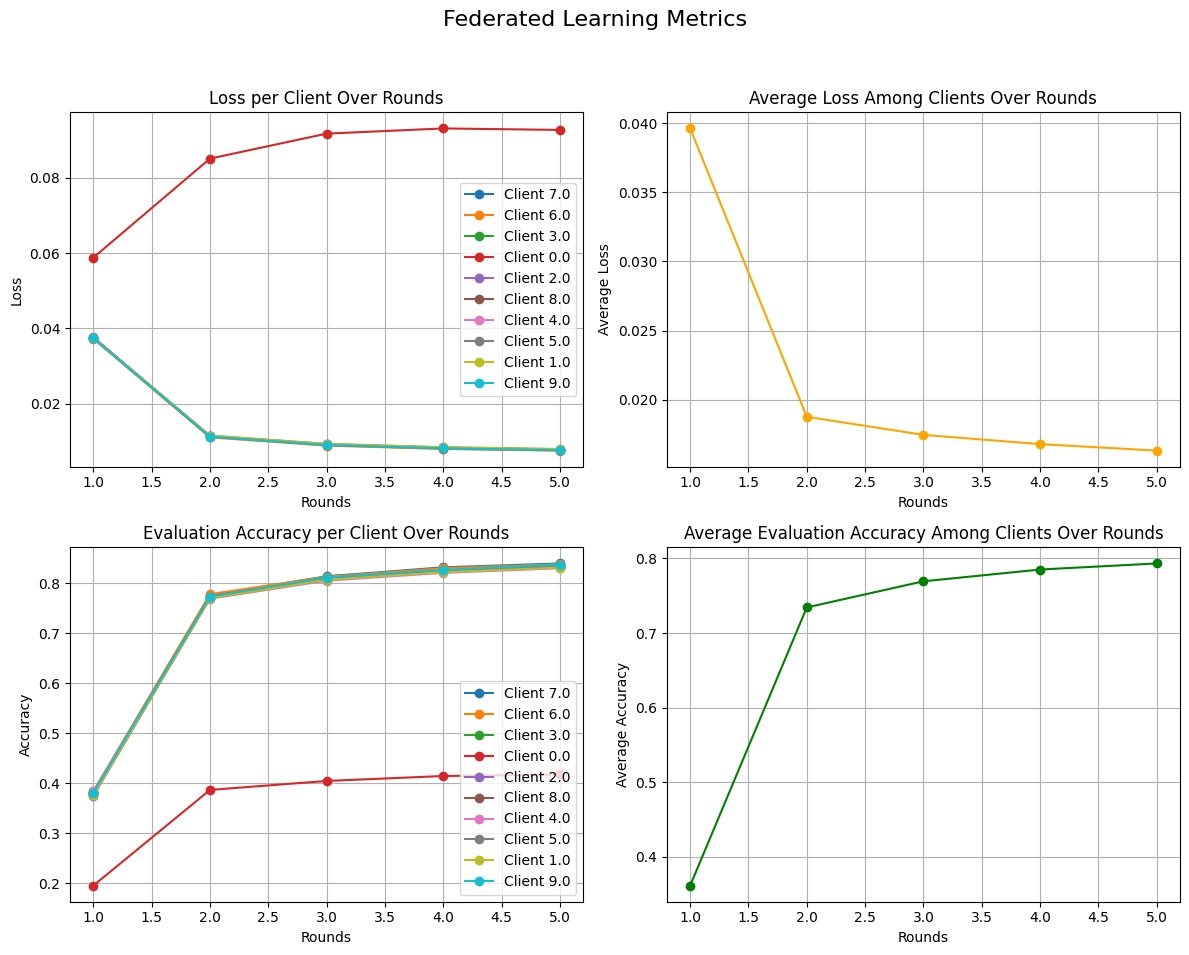

In [ ]:
visualize_results(file_name="metrics.csv")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
